In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os 
import sys
import pandas as pd
from dfm_functions import make_map, make_mask, cmap_discretize

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# data sources: 
# April 1 SWE from all GCMs
# ensemble average daily April 1 SWE: /raid9/gergel/agg_snowpack/goodleap/dailySWE
# April 1 SWE (yearly) for each GCM: /raid9/gergel/agg_snowpack/goodleap/tmp_GCM_SWE_time_period.nc 
# April 1 SWE average for entire time period and over GCMs (but maybe this should be verified, there's no readme
# describing how this data was made, GOD I HATE HOW I USED TO CODE) 
# where time period is historical, rcp45, rcp85 

In [3]:
GCMs = ['NorESM1-M', 'CSIRO-Mk3-6-0', 'CanESM2', 'HadGEM2-CC365', 'HadGEM2-ES365', 'MIROC5', 'CCSM4', 
        'IPSL-CM5A-MR', 'CNRM-CM5', 'bcc-csm1-1-m']
time_periods = ['historical', 'rcp45', 'rcp85']

get SWE data

In [4]:
# try concatenating arrays by GCM
direc = '/raid9/gergel/agg_snowpack/goodleap'
time_periods = ['historical', 'rcp85']

# create dictionary of datasets (historical, rcp85)
datasets = {}


for time_period in time_periods:
    # create dictionary of SWE DataArrays from each GCM
    ds_to_concat = {}
    for gcm in GCMs:
        filename = 'tmp_%s_SWE_%s.nc' % (gcm, time_period)
        ds2 = xr.open_dataset(os.path.join(direc, filename))
        ds_to_concat[gcm] = ds2['SWE']

    # concatenate DataArrays into one Dataset with new dimension 'GCM'
    datasets[time_period] = xr.concat(list(ds_to_concat.values()), 'GCM')

calculate numerator and denominator for T/P sensitivity plot

In [5]:
swe_future_high = datasets['rcp85'].sel(Time=slice('2040-04-01', '2069-04-01')).mean('Time').max('GCM')
swe_future_low = datasets['rcp85'].sel(Time=slice('2040-04-01', '2069-04-01')).mean('Time').min('GCM')
swe_future_mean = datasets['rcp85'].sel(Time=slice('2040-04-01', '2069-04-01')).mean('Time').mean('GCM')
swe_historic_mean = datasets['historical'].sel(Time=slice('1970-04-01', '1999-04-01')).mean('Time').mean('GCM')

metric = (swe_future_high - swe_future_low) / (swe_future_mean - swe_historic_mean)

In [6]:
# do preprocessing for plotting (e.g. making mask, clip Canada, and so forth)
mask_domain_mtns = make_mask('/raid9/gergel/agg_snowpack/gridcells_is_paper/mountains', 
                             metric.Latitude, metric.Longitude)

mask_domain_domain = make_mask('/raid9/gergel/agg_snowpack/gridcells_is_paper/all_regions', 
                              metric.Latitude, metric.Longitude)

full metric (absolute values)

saving figure to '/raid/gergel/absolute_t_p'


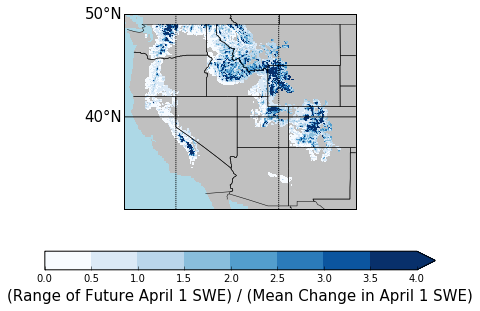

In [7]:
f = plt.figure(figsize=(7,5))
fs = 15 ## fontsize
from xarray import ufuncs

metric = (swe_future_high - swe_future_low) / (swe_future_mean - swe_historic_mean)
metric_masked = ufuncs.fabs(metric.where(mask_domain_mtns == 1))
m = make_map(fs, label_parallels=True)
x, y = m(metric_masked.Longitude, metric_masked.Latitude)
cmap = cmap_discretize(plt.cm.Blues, 8)
vmin = 0
vmax = 4
img = m.pcolormesh(x, y, metric_masked.to_masked_array(), vmin=vmin, vmax=vmax, cmap=cmap)
cbar = plt.colorbar(img, orientation='horizontal', extend='max')
cbar.set_ticks([np.linspace(vmin, vmax, 9, endpoint=True)])
cbar.set_label('(Range of Future April 1 SWE) / (Mean Change in April 1 SWE)', size=fs)

## save plot
direc = '/raid/gergel/'
if not os.path.exists(direc):
    os.makedirs(direc) ## if directory doesn't exist, create it
plotname = 'absolute_t_p'
savepath = os.path.join(direc, plotname)
print ("saving figure to '%s'" % savepath)
plt.savefig(savepath, dpi=300, bbox_inches='tight')

full metric, absolute values - different colorbar

saving figure to '/raid/gergel/absolute_t_p_diffcb'


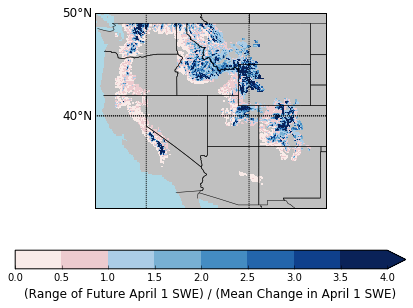

In [10]:
fs = 12 ## fontsize

f = plt.figure(figsize=(7,5))
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap_discrete = ListedColormap([[0.976, 0.92, 0.91], [0.93, 0.796, 0.81], [.67, .8, .9], [.47, .69, 0.827],
                                [0.266, 0.549, 0.76], [.137, .396, .67], [.0588, .25, .55], [.039, .133, .345]])

norm = BoundaryNorm([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], cmap_discrete.N)

metric = (swe_future_high - swe_future_low) / (swe_future_mean - swe_historic_mean)
metric_masked = ufuncs.fabs(metric.where(mask_domain_mtns == 1))
m = make_map(fs, label_parallels=True)
x, y = m(metric_masked.Longitude, metric_masked.Latitude)
cmap = cmap_discretize(plt.cm.coolwarm_r, 8)
vmin = 0
vmax = 4
img = m.pcolormesh(x, y, metric_masked.to_masked_array(), vmin=vmin, vmax=vmax, cmap=cmap_discrete)
cbar = plt.colorbar(img, orientation='horizontal', extend='max')
cbar.set_ticks([np.linspace(vmin, vmax, 9, endpoint=True)])
cbar.set_label('(Range of Future April 1 SWE) / (Mean Change in April 1 SWE)', size=fs)

## save plot
direc = '/raid/gergel/'
if not os.path.exists(direc):
    os.makedirs(direc) ## if directory doesn't exist, create it
plotname = 'absolute_t_p_diffcb'
savepath = os.path.join(direc, plotname)
print ("saving figure to '%s'" % savepath)
plt.savefig(savepath, dpi=300, bbox_inches='tight')